In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

## 3.8.6

In [3]:
N = 90_000
N_h = pd.Series([35000, 45000, 10000], ["house", "apartments", "condominium"])

### a

In [4]:
s = [2, 1, 1]
n = 900
n_h = N_h * s / np.sum(N_h * s) * n
print(f"allocation: {n_h}")

allocation: house          504.0
apartments     324.0
condominium     72.0
dtype: float64


### b

In [5]:
p_h = pd.Series([0.45, 0.25, 0.03], ["house", "apartments", "condominium"])
we = N_h / N
p_str = np.sum(p_h * we)

print(f"p from prop: {p_str}")
v_prop = np.sum(we**2 * p_h * (1 - p_h) / (n * we) * (1 - n / N) )
print("proportional stratified:")
print(f"variance: {v_prop}")
v_srs = (1 - n / N) * p_str * (1 - p_str) / n
print("simple random sampling:")
print(f"variance: {v_srs}")


p from prop: 0.3033333333333334
proportional stratified:
variance: 0.0002125566666666667
simple random sampling:
variance: 0.00023245444444444446


## 3.8.8

In [6]:
def get_n_h_with_costs(N_h, cost, budget):
    n_h_div_n = N_h / np.sqrt(cost) / np.sum(N_h / np.sqrt(cost))
    n = np.floor(np.sum(budget / (cost * n_h_div_n)))
    return np.floor(n_h_div_n * n)
    


costs = np.array([300, 400])
N_h_p = np.array([0.9, 0.1])
budget = 150_000
n_h = get_n_h_with_costs(N_h_p, costs, budget)
print(f"all in person allocation: {n_h}")

all in person allocation: [4396.  423.]


In [7]:
costs = np.array([100, 400])
n_h = get_n_h_with_costs(N_h_p, costs, budget)
print(f"telephone and in person allocation: {n_h}")

telephone and in person allocation: [8249.  458.]


## 3.8.25

In [8]:
acre = pd.DataFrame(
    np.array([[220, 1054, 1382, 422],
              [21, 103, 135, 41],
              [97629.8, 300504.2, 211315, 662295.5],
              [7647472708, 29618183543, 53587487856, 396185950266]]).T,
    columns=["N_h", "n_h", "y_bar", "s2"])

y_u = np.sum(acre["n_h"] / acre["N_h"] * acre["y_bar"])
r = 0.1
v_m = (r * y_u / 1.96) ** 2
n_h_div_n = acre["N_h"] * acre["s2"] / np.sum(acre["N_h"] * acre["s2"])
def get_v(n):
    return np.sum((n_h_div_n * n / acre["N_h"])**2 * acre["s2"] * (1 / (n_h_div_n * n) - 1 / acre["N_h"]))

def bisection_n():
    n_min = 1
    n_max = np.floor(np.min(acre["N_h"] / n_h_div_n))
    while n_max - n_min > 1:
        n_mid = np.round((n_min + n_max) / 2)
        v_mid = get_v(n_mid)
        if v_mid > v_m:
            n_min = n_mid
        else:
            n_max = n_mid
    return n_min

n = bisection_n()
n_h = n_h_div_n * n
print(f"required sample obs.: {n}")
print(f"allocation: {n_h}")

required sample obs.: 666.0
allocation: 0      4.087231
1     75.838121
2    179.911934
3    406.162714
dtype: float64


## 3.8.27

In [9]:
n = 1100
N = 15769
N_h = pd.Series([5803, 9966], ["female", "male"])
we_prop = N_h / N
print(f"proportional allocation: {we_prop * n}")
s = [11/5, 1]
n_h = N_h * s / np.sum(N_h * s) * n
print(f"Neyman allocation: {n_h}")

proportional allocation: female    404.800558
male      695.199442
dtype: float64
Neyman allocation: female    617.758637
male      482.241363
dtype: float64


## 3.8.50

In [21]:
baseball = pd.read_csv("./baseball.csv")
baseball["logsal"] = np.log(baseball["salary"])
baseball["is_pitcher"] = baseball["pos"] == "P"

### a

In [22]:
stratified_baseball = baseball.groupby("team", group_keys=False).apply(lambda x: x.sample(frac=150 / baseball.shape[0], random_state=2023))

### b

In [29]:
def get_mean_and_ci(sample_df, strata, target, N_h, we):
    n_h = sample_df.groupby(strata).size()
    y_bar = sample_df.groupby(strata)[target].mean()
    s2 = sample_df.groupby(strata)[target].var()
    y_str = np.sum(we * y_bar)
    v_m = np.sum((we)**2 * s2 * (1 / n_h - 1 / N_h))
    ci = stats.norm.interval(0.95, loc=y_str, scale=np.sqrt(v_m))
    return y_str, ci
    
p_pitcher, p_pitcher_ci = get_mean_and_ci(stratified_baseball, "team", "is_pitcher", baseball.groupby("team").size(), baseball.groupby("team").size() / baseball.shape[0])
print(f"proportion of pitchers: {p_pitcher}")
print(f"95% CI: {p_pitcher_ci}")

proportion of pitchers: 0.3959849435382685
95% CI: (0.3298682908550369, 0.46210159622150015)


### c

In [30]:
logsal, logsal_ci = get_mean_and_ci(stratified_baseball, "team", "logsal", baseball.groupby("team").size(), baseball.groupby("team").size() / baseball.shape[0])
print(f"mean log salary: {logsal}")
print(f"95% CI: {logsal_ci}")

mean log salary: 13.84882748784042
95% CI: (13.675176032005984, 14.022478943674857)


### d

(array([4., 4., 4., 3., 4., 6., 3., 0., 1., 1.]),
 array([0.02639362, 0.39229791, 0.7582022 , 1.12410649, 1.49001078,
        1.85591508, 2.22181937, 2.58772366, 2.95362795, 3.31953225,
        3.68543654]),
 <BarContainer object of 10 artists>)

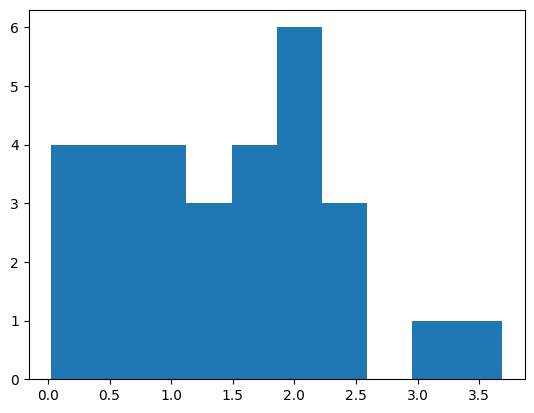

In [35]:
logsal_sample_var = stratified_baseball.groupby("team")["logsal"].var()
import matplotlib.pyplot as plt
plt.hist(logsal_sample_var)

### e

In [42]:
we = baseball.groupby("team").size() / baseball.shape[0]
n_h_div_n = we * logsal_sample_var / np.sum(we * logsal_sample_var)
n_h = n_h_div_n * 150
n_h = n_h.round()
diff = np.sum((stratified_baseball.groupby("team").size() - n_h)**2)
print(f"diff: {diff}")

diff: 279.0
